## Issuance of a PRC as QR code

In [11]:
# Load the private key from the PEM file
with open('private_key_ec.pem', 'rb') as f:
    private_key_pem = f.read()

In [12]:
# Compute fingerprint of private key
from helper import get_ec_private_key_fingerprint
fingerprint = get_ec_private_key_fingerprint(private_key_pem)
print("Hex-encoded fingerprint:", fingerprint)

Hex-encoded fingerprint: 3e47b334052d2575f1943c8af41026580810f88c30a236db0ef19bdd8a5d92a2


### EHIC data sample

In [13]:
sample_ehic_data = {
    "ic": "BE",
    "hn": {
        "fn": "Clément-Lafarge",
        "gn": "Jean-Pierre, Frédéric",
    },
    "dob": "29-02-2000",
    "hi": "0001019999",
    "ii": "0216X",
    "in": "LAMUTUALITENEUTRE",
    "ci": "021XXXXXXX2023035407",
    "sd": "28-02-2023",
    "ed": "29-02-2024",
    "id": "31-01-2024"
}
print("Approx. byte size:", len(str(sample_ehic_data)))

Approx. byte size: 249


### Create payload of verifiable credential
The credentialSubject is the actual EHIC data sample

In [14]:
verifiable_credential = {
    "@context": [
        "https://www.w3.org/2018/credentials/v1",
        "https://w3id.org/vc/status-list/2021/v1"
    ],
    "type": [
        "VerifiableCredential",
        "EHICCredential"
    ],
    "credentialSubject": sample_ehic_data,
    "credentialSchema": {
        "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
        "type": "FullJsonSchemaValidator2021"
    }
}
print("Approx. byte size:", len(str(verifiable_credential)))

Approx. byte size: 622


### Build JSON web token

In [15]:
import datetime
import json

# Define the content of the JWT
payload = {
    "iat": int(datetime.datetime.now().timestamp()),  # Issued at
    "nbf": int(datetime.datetime.now().timestamp()),  # Not before
    "exp": int((datetime.datetime.now() + datetime.timedelta(days=365)).timestamp()), # Expiration date
    "vc": verifiable_credential,
    "kid": f"BE:{fingerprint}", # Key identifier
    "iss": f"BE:0100", # Issuer
}

print(json.dumps(payload, indent=4))
print("Approx. byte size:", len(str(payload)))

{
    "iat": 1741264561,
    "nbf": 1741264561,
    "exp": 1772800561,
    "vc": {
        "@context": [
            "https://www.w3.org/2018/credentials/v1",
            "https://w3id.org/vc/status-list/2021/v1"
        ],
        "type": [
            "VerifiableCredential",
            "EHICCredential"
        ],
        "credentialSubject": {
            "ic": "BE",
            "hn": {
                "fn": "Cl\u00e9ment-Lafarge",
                "gn": "Jean-Pierre, Fr\u00e9d\u00e9ric"
            },
            "dob": "29-02-2000",
            "hi": "0001019999",
            "ii": "0216X",
            "in": "LAMUTUALITENEUTRE",
            "ci": "021XXXXXXX2023035407",
            "sd": "28-02-2023",
            "ed": "29-02-2024",
            "id": "31-01-2024"
        },
        "credentialSchema": {
            "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
            "type": "FullJsonSc

### Sign JWT

In [16]:
import jwt

encoded_jws = jwt.encode(payload, private_key_pem, algorithm='ES256')
print("Encoded JWS (JWT):", encoded_jws)
print("Approx. byte size:", len(encoded_jws))

Encoded JWS (JWT): eyJhbGciOiJFUzI1NiIsInR5cCI6IkpXVCJ9.eyJpYXQiOjE3NDEyNjQ1NjEsIm5iZiI6MTc0MTI2NDU2MSwiZXhwIjoxNzcyODAwNTYxLCJ2YyI6eyJAY29udGV4dCI6WyJodHRwczovL3d3dy53My5vcmcvMjAxOC9jcmVkZW50aWFscy92MSIsImh0dHBzOi8vdzNpZC5vcmcvdmMvc3RhdHVzLWxpc3QvMjAyMS92MSJdLCJ0eXBlIjpbIlZlcmlmaWFibGVDcmVkZW50aWFsIiwiRUhJQ0NyZWRlbnRpYWwiXSwiY3JlZGVudGlhbFN1YmplY3QiOnsiaWMiOiJCRSIsImhuIjp7ImZuIjoiQ2xcdTAwZTltZW50LUxhZmFyZ2UiLCJnbiI6IkplYW4tUGllcnJlLCBGclx1MDBlOWRcdTAwZTlyaWMifSwiZG9iIjoiMjktMDItMjAwMCIsImhpIjoiMDAwMTAxOTk5OSIsImlpIjoiMDIxNlgiLCJpbiI6IkxBTVVUVUFMSVRFTkVVVFJFIiwiY2kiOiIwMjFYWFhYWFhYMjAyMzAzNTQwNyIsInNkIjoiMjgtMDItMjAyMyIsImVkIjoiMjktMDItMjAyNCIsImlkIjoiMzEtMDEtMjAyNCJ9LCJjcmVkZW50aWFsU2NoZW1hIjp7ImlkIjoiaHR0cHM6Ly9hcGktcGlsb3QuZWJzaS5ldS90cnVzdGVkLXNjaGVtYXMtcmVnaXN0cnkvdjMvc2NoZW1hcy8weGZhODk5ZmQyYmMyYTVhNjZhZDUxZjk4ODE4MTM0MDFlYmUwMmY3ZGQ0MGIwOTI2YzNlNDljOTUxNGE3N2NiNmEiLCJ0eXBlIjoiRnVsbEpzb25TY2hlbWFWYWxpZGF0b3IyMDIxIn19LCJraWQiOiJCRTozZTQ3YjMzNDA1MmQyNTc1ZjE5NDNjOGFmNDEwMjY1ODA4MTBm

### Generate QR code

Compress encoded JWS using ZLib

In [17]:
import zlib
import base64

# Compress the JWS using zlib
compressed_jws = zlib.compress(encoded_jws.encode('utf-8'))

compressed_jws_b64 = base64.b64encode(compressed_jws).decode('utf-8')
print("Compressed JWS (base64):", compressed_jws_b64)
print("Approx. byte size:", len(compressed_jws))

Compressed JWS (base64): eJxdU9uymzgQ/KJscTHO4dHmZrGWKDAISy9bIJwgkDCJfQzi6yPscyrJPlBUDUx3T0/PRcVtHTGe8DgsFmAiDm5gyBzmgS3oxzP2Yvefi4pHck550gU28gOFutREXXAD0uGUgy3MmQFzYCG/sOBp4vTcTqC7zmhhKvF3E8rJfPRiiyiw1Vg7YrnvTYQ3jSYpVXxtDtnEluvjaDd2oxwbKufBJHvAbjcnntsxiXtaOkZVhjemXM2hRcrWaA77JeFvj2ZBI/VePY2ED2ZnbXPAy7GcR2anK46Cp7UvbrQO43LeC9CNNRBUMCmkxuV1hP0/eQCfeFa0cWogRctM1EM2knLiZz0fsWNBI6xnEG0dIpPIURBb+zPceFXC1Uwve2l81zxfgaT6feWpNbMm3000F/eV51jMLZWholbBta6h5k/TBSk39yISgg2xOHr7iInZhP5eJGX22a9Wnm+r15HLV2zY9Xfog7uedYLek3t81rX/MNc+5r2TPDWJjzqYkfi+8o4v3nmfY1zgIoQnnIV5jzEO43D1gVi9nglMsAtJGbbP5+npsltQnk5IraFB/UvH908dCq517en/9Cn01Cde9SXQ9eCjHrtaz1/7Lix0paXZvnx89VSHzGAHuD0qt2VRf2eRuNV2+k7LeKlOjmhOrsEGvOiM9ccz6qoI38kZ3jXuUJ2R/tY/mk7n5AObqbfpEtE28XuHylQRCRXJcYs62lK/mGnXbxI/2MAcGtAPBZHFBCWxaZQaMAJTorNPFiSQL7okL2YU6TuxEEcy4L/zduXZgG91MC615eTEakVdhiXRGaVRaNQ2UOtOwGCuHvysyvSVo/y60Dy1SQcX5O9MqPWhnJm0Cxzkoy6JQqlvUu+GmPrWtMa9TPxW/71vYQctqvXRksxJGffUb1tUpg6UgVr3qr1Ynrnsiy1cMdZjD9/22//eDDk/LBrG1TfvYgIUBi4qt9axQu44wC1

Encode the compressed data using Base45

In [18]:
import base45

base45_encoded = base45.b45encode(compressed_jws)
print("Base45 encoded JWS:", base45_encoded)
print("Approx. byte size:", len(base45_encoded))

Base45 encoded JWS: b'6BF-ZB$YR1SJS620OK.DE-6Q4OQ9:CA:IB36WM9INB8XJCAI7HHDS1UWT6+TII5M*77SA0U981A69Q6/O3V384KP47D$2XD4-.DIDPE6T7 5A8PT6VVDV$SHK19J-9ZOQQ.61K0%RN-S8A7EUTQ*YIOZ5JFJGQE:B4AGMGHD:.UD.9IXN 8DDJ5I2FSSP%ZFRKCL65V/Q$M7YMN:Z91174$4E AIZD%NRP3JVXSN07-RKOJ3JDTOR4WEOY/6W3K B6XQFNG7O AQ17.WBKHK-SP/6DXXVLMSZ5IPA8*0V7Z7CVGP.CT$DZGOIKM81906LW0I39L$:5EYM-XS83SJGQ*V6.SA+B5M6PO%EV0WGDF97KB/A9FEQ34OVPO$QK+6PNEE2DD04TOC.M4E1DXZDVG4QEP2322YVA*R*$AJ/Q5064FDK9RE3CO%K9-FRHL7TMFASFQ6LDV4BTO PA-INNK:LOK3M95TLUQL95-AVDF2+W1D67.ZV9JHQ GP+B2+CHNRY.AC5EFBRZVP9YDJ1VXHTFWNM%E96SMRFK6RXBWM9RT7TRRIPY6 4I.CJ3KV*TUE26+GFBPC3FS VGJZJOGF396*XST1V$9B2:JCV99J1CB3XCQVPTTOMS8AF+9Y.LIF84Q9-BV9U3L2MK3U4GWUD5- Q90C5Z4Y3V/RK$UNW9Q.XV+R5F.KWNR8XFT0VO7HD6C5DN0I5H CZ4G:IIG:Q/SVNWP7IL60IR.94IOU*N+ HA8P:TTL511JP54SX5UH-JX9W$18*/96$SOUJBBN2H2P.6XRF1QP-62.X2.FE J7XKA2CJQAR D23IR*O3SDQUV0 +OJY4SFD:D3AD0QPK-:90S4N16%P4W+C$LTDHM109PIS1ZUQ2TTAGU EW+5$2TH$ORY86/GOJQL+KGBD:%6SXTIEOO0MJ.VQTPC-IX.VSEQE-MF+0H.S4V9G2V*ZJBYMGT3ESK%FH

Generate QR code

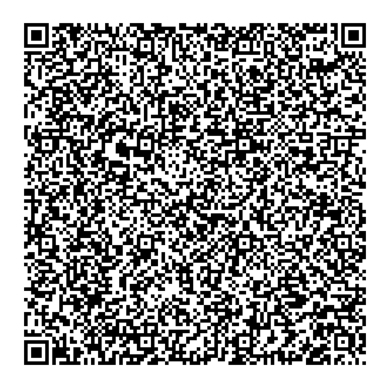

In [19]:
import qrcode
import matplotlib.pyplot as plt

# Create a QR code instance
qr = qrcode.QRCode(
    version=1,  # Controls the size of the QR Code
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)

qr.add_data(base45_encoded)
qr.make(fit=True)

# Create an image from the QR code instance
img = qr.make_image(fill='black', back_color='white')
img.save("qrcode.png")


# Display the image in the notebook
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()

### Make a PDF

In [20]:
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader


# Create a canvas object
c = canvas.Canvas("prc.pdf", pagesize=A4)
width, height = A4

# Set font and size for the text
c.setFont("Helvetica", 12)

# Add text element of EHIC data
i = 0
for key, value in sample_ehic_data.items():
    i += 1
    c.drawString(100, height - 100 - 20 * i, f'{key}: {value}')

# Add QR code to PDF
y_position = height - 320 - 20 * i
img = ImageReader("qrcode.png")
c.drawImage(img, 100, y_position, width=200, height=200, mask='auto')

# Save the PDF file
c.save()